## Análisis inicial de ratings

El objetivo de este trabajo es obtener un rating para una compañia, a partir de sus principales ratios de solvencia. Ya que muchas de las compañías no tiene rating y es una métrica importante a la hora de calcula la tasa de descuento necesari para hacer una valoración.

Importamos los modulos necesarios:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import matplotlib.ticker as mtick
from standard_data import var_x_num, All_rating_order, All_rating_order_group, rating_order_group

# ggplot style
plt.style.use('ggplot')

Importamos los datos ya agrupados u dejamos una base de datos limpia, esto se hacen en este [notebook](./1_Carga_Datos.ipynb). 

Pendiente: Explicar que metricas son las que vamos a utlizar y porque son importantaes.

In [2]:
var_x_cat = ['Sector']
var_x = var_x_num + var_x_cat
all_var_x = ['Excel Company ID'] +var_x
var_y = ['Rating']
df = pd.read_csv("all_Data.csv")
df.head()

,Excel Company ID,Rating,Sector,Company Name,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,...,year,Net Debt to EBITDA,Debt to Assets,Long Term Debt to Equity,Financial Leverage,Current Ratio,Quick Ratio,Cash ratio,Debt to Equity,Debt ratio
0,IQ18759,NR,Financials,0.0,310.06605,228.73725,27.59370,4363.43535,14.81346,578.01540,...,2014,1.724823,0.135203,0.155287,1.172259,20.931373,17.303922,15.441176,0.156340,7.498128
1,IQ8316305,NR,Consumer Discretionary,0.0,51.88777,40.04790,2.87628,853.42013,24.49449,236.99067,...,2014,4.458441,0.288306,0.400832,1.443425,2.118345,1.752401,1.634976,0.405099,3.563143
2,IQ26972930,#REFRESH,Financials,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IQ10838992,NR,Energy,0.0,36.34308,23.12788,13.01261,157.14467,32.76171,76.24575,...,2014,3.145914,0.646339,1.776800,3.662036,1.109316,1.103132,0.705942,1.827566,2.003778
4,IQ26287294,NR,Financials,0.0,0.00000,1838.74759,0.00000,27968.75430,0.00000,0.00000,...,2014,-inf,0.000000,0.000000,5.685754,NaN,inf,inf,0.000000,inf


## Preparacion
Nos quedamos unicamente con las metricas importantes y vemos el numero de varaibles para cada métrica


In [3]:
# Count the number of values different from NaN in all columns
df.count()

Excel Company ID            82837
Rating                      82837
Sector                      82837
Company Name                42643
Current Assets              82718
Cash and equivalents        82718
Receivables                 82718
Total Assets                82718
Current Liabilities         82718
Long Term Debt              82718
Total Debt                  82718
Total Equity                82718
Gastos financieros netos    82718
EBITDA                      54922
year                        82837
Net Debt to EBITDA          54229
Debt to Assets              75748
Long Term Debt to Equity    75729
Financial Leverage          75962
Current Ratio               74977
Quick Ratio                 75857
Cash ratio                  75705
Debt to Equity              75748
Debt ratio                  75933
dtype: int64

In [4]:
# and count the number of unique values in each column
df.nunique()

Excel Company ID            10437
Rating                         27
Sector                         13
Company Name                    2
Current Assets              74094
Cash and equivalents        69747
Receivables                 70303
Total Assets                75403
Current Liabilities         74029
Long Term Debt              64786
Total Debt                  68615
Total Equity                74569
Gastos financieros netos    46392
EBITDA                      47328
year                           10
Net Debt to EBITDA          47557
Debt to Assets              69318
Long Term Debt to Equity    65729
Financial Leverage          75121
Current Ratio               74264
Quick Ratio                 74113
Cash ratio                  72212
Debt to Equity              69317
Debt ratio                  69350
dtype: int64

In [5]:
# show the unique values in the 'Rating' and sector column
print(df['Rating'].unique())
print(df['Sector'].unique())

['NR' '#REFRESH' '0' 'BBB' 'AAA' 'AA+' 'AA' 'AA-' 'A+' 'A' 'A-' 'BBB+'
 'BBB-' 'BB+' 'BB' 'BB-' 'B+' 'B' 'CCC+' 'B-' 'CCC-' 'CCC' 'CC' 'D' 'SD'
 '(Invalid Identifier)' '#PEND']
['Financials' 'Consumer Discretionary' 'Energy' 'Communication Services'
 'Industrials' 'Materials' 'Utilities' 'Consumer Staples'
 'Information Technology' 'Health Care' 'Real Estate' '0'
 '(Invalid Identifier)']


In [6]:
#Mira que categorias de rating no tenemos
comp_with_not_rating =set(df['Rating'].unique()) - set(All_rating_order)
comp_with_not_rating

{'#PEND', '#REFRESH', '(Invalid Identifier)', '0', 'NR'}

In [7]:
# ver cuantas filas en la columna de rating tiene los valores rows_pendientes
print(f" Filas totales: {df.shape[0]}\n",
      f"Filas con rating  {df[df['Rating'].isin(All_rating_order)].shape[0]}\n",
      f"Filas sin rating  {df[df['Rating'].isin(comp_with_not_rating)].shape[0]}")

#count the number each rating appear
df[df['Rating'].isin(comp_with_not_rating)]['Rating'].value_counts()


 Filas totales: 82837
 Filas con rating  52592
 Filas sin rating  30245


Rating
NR                      29705
0                         420
(Invalid Identifier)      118
#REFRESH                    1
#PEND                       1
Name: count, dtype: int64

Uno de los sesgos que cometeremos es que solo estaremos usando las compañias com rating lo cual puede hacer un sesgo hacia compañías grandes. Por tanto analizamos si hay diferencia significativa en las metricas entre compañías con y sin raing

1) Hacer una columna que defina cual tiene y no tiene rating
2) Hacer el test que he hecho en (link a estudio datos)

In [8]:
df_test = df.dropna(subset=var_x_num)
df_test['Rating'].unique()

array(['NR', '0', 'BBB', 'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-',
       'BBB+', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'CCC+', 'B-',
       'CCC-', 'CCC', 'CC', 'SD', 'D'], dtype=object)

In [9]:
df_test.loc[:,'Rating_'] = df_test['Rating'].apply(lambda x: 'rated' if x in All_rating_order else 'not rated')
print(df_test.shape)
df_test.head()

(53025, 25)


C:\Users\Ruben\AppData\Local\Temp\ipykernel_5152\4025640651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,'Rating_'] = df_test['Rating'].apply(lambda x: 'rated' if x in All_rating_order else 'not rated')


,Excel Company ID,Rating,Sector,Company Name,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,...,Net Debt to EBITDA,Debt to Assets,Long Term Debt to Equity,Financial Leverage,Current Ratio,Quick Ratio,Cash ratio,Debt to Equity,Debt ratio,Rating_
0,IQ18759,NR,Financials,0.0,310.06605,228.73725,27.59370,4363.43535,14.81346,578.01540,...,1.724823,0.135203,0.155287,1.172259,20.931373,17.303922,15.441176,0.156340,7.498128,not rated
1,IQ8316305,NR,Consumer Discretionary,0.0,51.88777,40.04790,2.87628,853.42013,24.49449,236.99067,...,4.458441,0.288306,0.400832,1.443425,2.118345,1.752401,1.634976,0.405099,3.563143,not rated
3,IQ10838992,NR,Energy,0.0,36.34308,23.12788,13.01261,157.14467,32.76171,76.24575,...,3.145914,0.646339,1.776800,3.662036,1.109316,1.103132,0.705942,1.827566,2.003778,not rated
5,IQ159979,NR,Financials,0.0,372.81195,372.81195,0.00000,14152.88135,2010.58736,0.00000,...,-inf,0.000000,0.000000,2.961626,0.185424,0.185424,0.185424,0.000000,inf,not rated
6,IQ24749,NR,Communication Services,0.0,58.35815,1.85357,35.35829,450.67163,76.01427,376.09027,...,10.388760,1.183633,-6.445641,-7.723857,0.767726,0.489538,0.024385,-6.445641,1.198307,not rated


In [10]:
# count the number of rows for each unique valoe un rating_
df_test['Rating_'].value_counts()

Rating_
rated        35190
not rated    17835
Name: count, dtype: int64

Realizar la prueba de Kruskal-Wallis para ver si hay diferencia entre los datos 'rated' y 'not rated' de la columna 'Net Debt to EBITDA'

In [11]:
alpha = 0.05
for i, var in enumerate(var_x_num):
    p = kruskal(*[group[var].values for name, group in df_test.groupby('Rating_')])[1]
    if p <= alpha:
        print(f"La diferencia entre los grupos para la varaible {var: <30} es significativa (p-value={p})")
    else:
        print(f"La diferencia entre los grupos para la varaible {var: <30}  no es significativa (p-value={p})")


La diferencia entre los grupos para la varaible Net Debt to EBITDA              no es significativa (p-value=nan)
La diferencia entre los grupos para la varaible Debt to Assets                 es significativa (p-value=8.020778485497533e-221)
La diferencia entre los grupos para la varaible Current Ratio                  es significativa (p-value=4.257091039901701e-10)
La diferencia entre los grupos para la varaible Quick Ratio                    es significativa (p-value=9.008554356294235e-09)
La diferencia entre los grupos para la varaible Cash ratio                     es significativa (p-value=0.00016213070538025957)
La diferencia entre los grupos para la varaible Long Term Debt to Equity       es significativa (p-value=0.0)
La diferencia entre los grupos para la varaible Debt to Equity                 es significativa (p-value=1.6105226150651205e-291)
La diferencia entre los grupos para la varaible Debt ratio                     es significativa (p-value=2.0504003238582696e-174)
La

XXX Problema: las compañias que no tiene rating tiene medias significativament diferetes que las que tiene rating

Eliminamos las compañias sin rating

In [12]:
rows_pendientes =set(df['Rating'].unique()) - set(All_rating_order)
print(rows_pendientes)
print('Todos los datos de antes',df.shape)
df = df[~df['Rating'].isin(rows_pendientes)]
print('Los datos de ahora',df.shape)
df.head()

{'#REFRESH', '(Invalid Identifier)', '#PEND', 'NR', '0'}
Todos los datos de antes (82837, 24)
Los datos de ahora (52592, 24)


,Excel Company ID,Rating,Sector,Company Name,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,...,year,Net Debt to EBITDA,Debt to Assets,Long Term Debt to Equity,Financial Leverage,Current Ratio,Quick Ratio,Cash ratio,Debt to Equity,Debt ratio
1274,IQ4149300,BBB,Industrials,NaN,1386.39413,473.54221,564.48206,4850.44019,401.58415,557.97548,...,2014,0.711890,0.159156,0.159270,1.384523,3.452313,2.584824,1.179186,0.189282,7.314621
2392,IQ5522615,AAA,Industrials,0.0,131.88622,40.31142,79.35595,948.46022,375.10682,140.04878,...,2014,1.942794,0.449078,0.383045,2.594117,0.351596,0.319022,0.107467,0.815138,3.182428
2393,IQ214177813,AAA,Industrials,0.0,126855.00000,930.00000,125925.00000,175980.00000,11.00000,155711.00000,...,2014,inf,0.948784,18.523793,20.935046,11532.272727,11532.272727,84.545455,18.525101,1.130091
2394,IQ883086,AAA,Financials,0.0,29418.00000,1469.00000,52.00000,131183.00000,50030.00000,70742.00000,...,2014,NaN,0.971622,20.624490,38.245773,0.588007,0.030402,0.029362,34.238484,1.117040
2395,IQ4112645,AAA,Industrials,0.0,19851.15657,1694.92907,17057.47764,59124.55826,12387.79077,36441.35861,...,2014,16.539510,0.975040,32.641924,52.960138,1.602478,1.513781,0.136823,39.064605,1.355706


## Estudio de los datos

Ahora vemos la distribucion de los datos para las variables categoricas

In [13]:
set(df['Rating'])-set(All_rating_order_group.keys())
# All the ratings are in the dictionary

set()

In [14]:
# create a new column in the dataframe with the rating grouped
df['Rating_group'] = df['Rating'].map(All_rating_order_group)

Tenemos muchos na asi que vamos a analizar lso datos

In [15]:
df.isna().sum()

Excel Company ID                0
Rating                          0
Sector                          0
Company Name                27153
Current Assets                  0
Cash and equivalents            0
Receivables                     0
Total Assets                    0
Current Liabilities             0
Long Term Debt                  0
Total Debt                      0
Total Equity                    0
Gastos financieros netos        0
EBITDA                      16386
year                            0
Net Debt to EBITDA          16579
Debt to Assets                953
Long Term Debt to Equity      960
Financial Leverage            871
Current Ratio                1602
Quick Ratio                   914
Cash ratio                    930
Debt to Equity                953
Debt ratio                    883
Rating_group                    0
dtype: int64

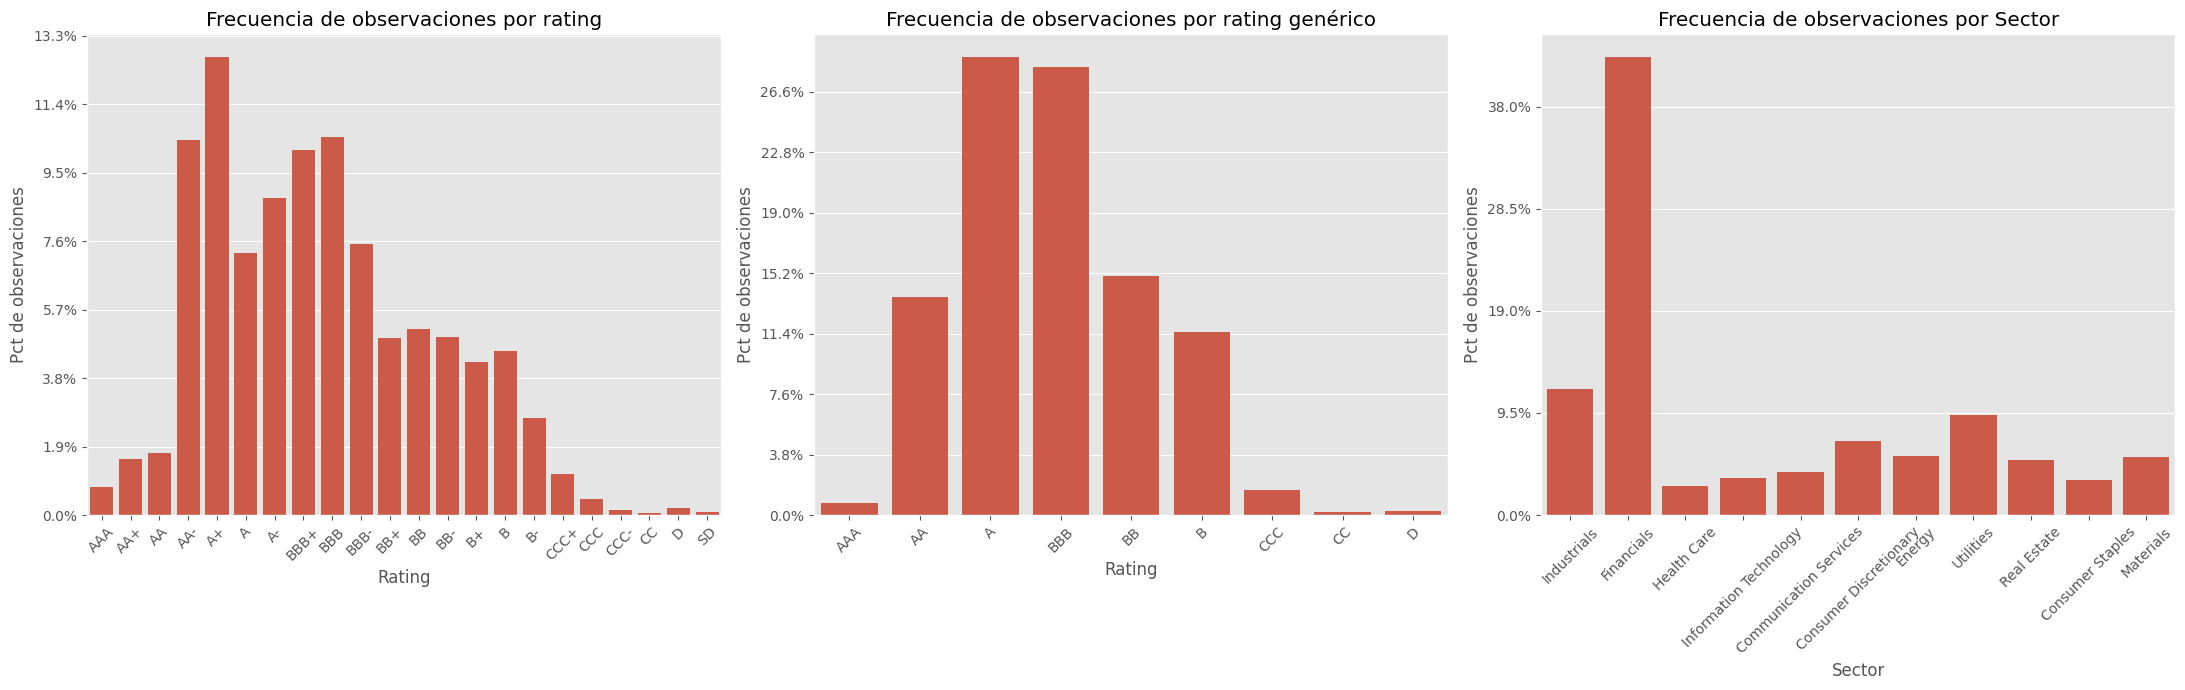

In [16]:
# create a figure and subplots with one row and three columns
fig, axs = plt.subplots(1, 3, figsize=(22, 7))

# plot the number of observations per rating
sns.countplot(x='Rating', data=df, order=All_rating_order, ax=axs[0])
axs[0].set_title('Frecuencia de observaciones por rating')
axs[0].set_ylabel('Pct de observaciones')
axs[0].set_xlabel('Rating')
axs[0].tick_params(axis='x', rotation=45)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))

# plot the results by Rating_group
sns.countplot(x='Rating_group', data=df, order=All_rating_order_group.values(), ax=axs[1])
axs[1].set_title('Frecuencia de observaciones por rating genérico')
axs[1].set_ylabel('Pct de observaciones')
axs[1].set_xlabel('Rating')
axs[1].tick_params(axis='x', rotation=45)
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))

# plot the number of observations per sector different from 0
sns.countplot(x='Sector', data=df[df['Sector'] != '0'], ax=axs[2])
axs[2].set_title('Frecuencia de observaciones por Sector')
axs[2].set_ylabel('Pct de observaciones')
axs[2].set_xlabel('Sector')
axs[2].tick_params(axis='x', rotation=45)
axs[2].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))


# adjust the spacing between subplots
plt.tight_layout()

# display the plot
plt.show()

XXX Problema: Los datos no estas distribudiso proporcionalmente y por tantoeel modelo solo predice los rating más frecuentes. En la seccion de [Ajustes](#ajustes) solucionamos esto mutiplicando los datos menos frecuencias (pero esto lo hacemos despues de limpiar los datos)

Primero analizamos por una categoría un poco más amplia

In [17]:
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(subset=var_x_num, inplace=True)
# drop the rows with inf values
var_x_num+['Rating_group']
# remove the column Company Name from the list of columns
del df['Company Name']

Ahora vemos la distribución de nuestro datos.

In [18]:
df[var_x_num].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Net Debt to EBITDA,31804.0,2.211630e+00,3.249918e+02,-23674.895570,1.286739,2.972850,5.385113,3.720445e+04
Debt to Assets,31804.0,5.311928e-01,1.652389e+00,-169.392654,0.335428,0.486855,0.645274,2.049051e+02
Current Ratio,31804.0,3.697774e+00,1.892674e+02,-1.810261,0.866444,1.270116,1.895173,2.892350e+04
Quick Ratio,31804.0,2.827609e+00,1.890468e+02,0.000000,0.459648,0.760971,1.168547,2.892350e+04
Cash ratio,31804.0,6.677049e-01,2.262678e+01,-0.012686,0.098700,0.252840,0.530431,3.866798e+03
Long Term Debt to Equity,31804.0,3.349716e+06,3.455330e+08,-15484.047507,0.310383,0.679990,1.229207,3.852078e+10
Debt to Equity,31804.0,3.786802e+06,3.907657e+08,-20581.063201,0.425825,0.853505,1.542019,4.395618e+10
Debt ratio,31804.0,1.160292e+03,1.386482e+05,0.001959,2.064387,2.909251,4.534653,2.431233e+07
Financial Leverage,31804.0,1.636661e+07,1.686120e+09,-29501.090541,1.988365,2.735626,4.070094,1.785409e+11


Como algunos de las ratios tiene mucha dispersion tenemos que ver como reducirlos, asi que iremos sobre los 5 ratios con dispersion para analizarlos con más detalle


1) Net Debt to EBTIDA: conocido como Leverage Ratio nos dice cuantos años con ese EBITDA necesitas para pagar tu deuda, de esta forma podemos saber cuanto riesgo de default tiene la empresa?
2) Debt to Assets: esto debería de ser un % que vaya de 0 a 100% reflejando el apalancamiento de la compañía, analizaremos el numerodor y denominador
3) Long Term DEbt to Equity: Esto debería también ser un un % que vaya de 0 a un numero menor 100%, analizaremos el numerodor y denominador
4) Debt to equity: esto debería de ser un ratop que vaya de 0 a X reflejando el cauntas veces tu deuda es el equit de la compañía, analizaremos el numerodor y denominador
5) Financial Leverage, deberia ir de 100% a un numero no muy grande, ya que implicaría que no hay ccasi equity sobre el total de activos

### Net Debt to EBITDA

1) Net Debt to EBTIDA, conocido como Leverage Ratio no dice cuantas veces tu deuda total es tu EBITDA, y es uno delo ratio mas seguidos. De esta forma podemos saber cuantos años necesitas para pagar tu deuda de manera aproximada. El problema es que:
    - El EBTIDA puede estar cerca de 0, lo cual dispararía el valor tanto a +inf como -inf.
    - La Deuda neta puede ser 0 o negativa ya que puedes tener más caja que deuda, aunque esto no es muy frecuenta.

    Por tanto, vamos a analizar los caso den los que:
    - EBITDA > 0 y Net Debt > 0 -> dejar el dato como esta. Y poner un maximo apartir del cual ya no pueda ser peor.
    - EBITDA > 0 y Net Debt < 0 -> Poner un 0 ya que esté sería el mejor  y por tanto le asignamos el mejor escenarios.
    - EBITDA < 0 y Net Debt < 0 -> Este sería el peor caso asi que tendremos que poner un valor y definir este como el maximo.
    - EBITDA < 0 y Net Debt > 0 -> Este es un caso raro, veremos cuantos hay.

In [19]:
# compute the Net Debt para analizar cad caso
df['Net Debt'] = df["Total Debt"] - df["Cash and equivalents"]
df.describe()

,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,Total Debt,Total Equity,Gastos financieros netos,EBITDA,...,Net Debt to EBITDA,Debt to Assets,Long Term Debt to Equity,Financial Leverage,Current Ratio,Quick Ratio,Cash ratio,Debt to Equity,Debt ratio,Net Debt
count,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,31804.000000,3.180400e+04,...,31804.000000,31804.000000,3.180400e+04,3.180400e+04,31804.000000,31804.000000,31804.000000,3.180400e+04,3.180400e+04,3.180400e+04
mean,7.436707e+03,1.385232e+03,2.164792e+03,2.574133e+04,6.463804e+03,7.572729e+03,9.177893e+03,2.709011e+03,-163.626930,1.277386e+03,...,2.211630,0.531193,3.349716e+06,1.636661e+07,3.697774,2.827609,0.667705,3.786802e+06,1.160292e+03,7.792661e+03
std,4.646230e+04,1.020540e+04,2.275476e+04,8.528010e+04,5.906428e+04,2.338828e+05,2.340867e+05,3.167924e+05,574.795624,3.407352e+04,...,324.991762,1.652389,3.455330e+08,1.686120e+09,189.267355,189.046822,22.626783,3.907657e+08,1.386482e+05,2.265279e+05
min,-1.666357e+03,-1.689010e+00,-3.291152e+00,7.438200e-01,1.810000e-02,-1.712520e+00,5.450000e-04,-3.473561e+07,-25093.483631,-4.141102e+06,...,-23674.895570,-169.392654,-1.548405e+04,-2.950109e+04,-1.810261,0.000000,-0.012686,-2.058106e+04,1.958755e-03,-5.825240e+04
25%,4.047912e+02,5.727733e+01,1.179098e+02,2.379313e+03,3.150776e+02,5.680718e+02,7.252960e+02,6.526799e+02,-162.146100,1.782355e+02,...,1.286739,0.335428,3.103826e-01,1.988365e+00,0.866444,0.459648,0.098700,4.258247e-01,2.064387e+00,4.353959e+02
50%,1.317724e+03,2.614774e+02,3.881558e+02,6.281265e+03,9.859296e+02,1.590576e+03,2.008768e+03,1.957915e+03,-58.609646,5.004876e+02,...,2.972850,0.486855,6.799904e-01,2.735626e+00,1.270116,0.760971,0.252840,8.535052e-01,2.909251e+00,1.472114e+03
75%,4.598304e+03,9.881602e+02,1.324555e+03,1.869849e+04,3.562837e+03,4.330507e+03,5.456339e+03,6.059902e+03,-19.794183,1.465355e+03,...,5.385113,0.645274,1.229207e+00,4.070094e+00,1.895173,1.168547,0.530431,1.542019e+00,4.534653e+00,4.225824e+03
max,3.769182e+06,1.511420e+06,1.825850e+06,5.071874e+06,6.588928e+06,2.480969e+07,2.480969e+07,4.527779e+05,8883.029026,1.342614e+05,...,37204.447972,204.905106,3.852078e+10,1.785409e+11,28923.495028,28923.495028,3866.797939,4.395618e+10,2.431233e+07,2.417670e+07


- EBITDA > 0 y Net Debt > 0 -> dejar el dato como esta y ponemos un maximo apartir del cual ya no se pueda hacer.

In [20]:
mask = (df['EBITDA']>0) & (df['Net Debt']>0)
df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
EBITDA,28380.0,1728.461499,4370.646166,0.026747,205.352940,530.115323,1514.773981,134261.418500
Net Debt,28380.0,5513.428367,14317.395011,0.002090,629.409915,1734.007568,4687.797585,658523.103250
Net Debt to EBITDA,28380.0,10.208148,245.535196,0.000197,1.809177,3.372772,5.734721,37204.447972


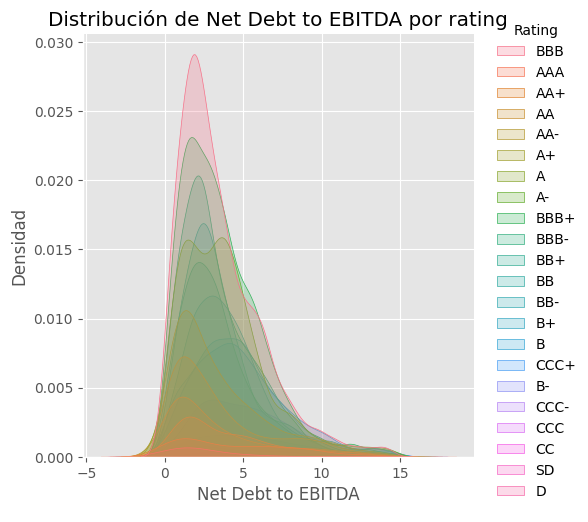

In [21]:
# plot the distrubution of the column 'Net Devt to EBITDA' with displot by rating_group
variable = 'Net Debt to EBITDA'
percentile = 95
df_test = df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating']]
# filter the data by the percentile 95
df_test = df_test[df_test[variable] <= np.percentile(df_test[variable], percentile)]

sns.displot(data=df_test, x=variable, hue='Rating', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

15 parece el el valor maáximo asi que cortaremos en 15

In [22]:
np.percentile(df[variable], 95)

13.929849696681842

In [23]:
df['Net Debt to EBITDA'].describe()

count    31804.000000
mean         2.211630
std        324.991762
min     -23674.895570
25%          1.286739
50%          2.972850
75%          5.385113
max      37204.447972
Name: Net Debt to EBITDA, dtype: float64

In [24]:
mask = (df[variable] >= np.percentile(df[variable], percentile)) & (df['EBITDA']>0) & (df['Net Debt']>0)
df[mask][['Rating','Net Debt to EBITDA']]

,Rating,Net Debt to EBITDA
2395,AAA,16.539510
2404,AAA,19.803120
2416,AAA,21.303006
2457,AA+,72.343802
2467,AA+,48.144609
...,...,...
82704,A-,18.835411
82752,BB-,20.119223
82759,B-,26.514745
82773,BB+,64.972326


In [25]:
serie_rating_filter = df[mask][['Rating']].value_counts()
serie_rating_count = df[['Rating']].value_counts()
serie_rating_filter = serie_rating_filter.reindex(serie_rating_count.index)

print(np.round(serie_rating_filter/serie_rating_count * 100,1))

Rating
BBB        3.3
BBB+       3.3
A-         4.3
BBB-       3.8
BB         3.1
BB+        3.0
BB-        4.3
A          4.8
B+         5.4
B          7.4
A+         7.5
B-         7.5
AA-        6.1
AA        10.1
CCC+      15.2
AA+       11.9
CCC        2.7
AAA       18.4
D         16.5
CCC-       6.8
SD         8.8
CC         4.3
Name: count, dtype: float64


No las podemos eliminar porque perdemos muchas datos de los que tenemos  pocos?

In [26]:
df[mask][['Rating','Net Debt to EBITDA']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Net Debt to EBITDA,1557.0,120.7738,1042.342085,13.929903,17.393646,24.469771,45.6504,37204.447972


In [27]:
df[['Rating','Net Debt to EBITDA']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Net Debt to EBITDA,31804.0,2.21163,324.991762,-23674.89557,1.286739,2.97285,5.385113,37204.447972


Pero es muy uimportante elminar estos extremos porque son caso aislados asi que los quitamos t vemos el impacto en los estadisticso

In [28]:
df.loc[mask,'Net Debt to EBITDA'] = 15
df[['Rating','Net Debt to EBITDA']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Net Debt to EBITDA,31804.0,-2.966643,227.498232,-23674.89557,1.286739,2.97285,5.385113,3905.711376


- EBITDA > 0 y Net Debt < 0 -> Poner un 0 ya que esté sería el mejor escenario

In [29]:
mask = (df['EBITDA']>0) & (df['Net Debt']<=0)
df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EBITDA,2425.0,1899.420103,5124.602274,0.222887,165.446106,518.845650,1608.403800,66644.974282
Net Debt,2425.0,-1300.351350,3372.845005,-58252.399999,-1038.607000,-312.065307,-86.791744,0.000000
Net Debt to EBITDA,2425.0,-5.230004,69.741608,-3125.299180,-1.485390,-0.632792,-0.235808,0.000000


Lo mismo para este caso

In [30]:
# over write all the row values of the column 'Net Debt to EBITDA' that are in mask with 0
df.loc[mask,'Net Debt to EBITDA'] = 0

df[['Net Debt to EBITDA']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Net Debt to EBITDA,31804.0,-2.567864,226.682255,-23674.89557,1.286739,2.97285,5.385113,3905.711376


- EBITDA < 0 y Net Debt > 0 -> Este sería el peor caso asi que tendremos que poner el valor maximo que hemos definido

In [31]:
mask = (df['EBITDA']<0) & (df['Net Debt']>0)

serie_rating_filter = df[mask][['Rating']].value_counts()
serie_rating_count = df[['Rating']].value_counts()
serie_rating_filter = serie_rating_filter.reindex(serie_rating_count.index)

print(np.round(serie_rating_filter/serie_rating_count * 100,1))

df[mask][['EBITDA','Net Debt','Net Debt to EBITDA']].describe().transpose()


Rating
BBB        0.9
BBB+       1.1
A-         1.8
BBB-       1.9
BB         1.7
BB+        1.1
BB-        3.3
A          2.9
B+         4.5
B          3.5
A+         2.9
B-         8.7
AA-        2.7
AA         2.9
CCC+      11.4
AA+        4.4
CCC        5.3
AAA       14.9
D         13.9
CCC-       1.4
SD         5.9
CC        21.7
Name: count, dtype: float64


,count,mean,std,min,25%,50%,75%,max
EBITDA,837.0,-15493.331978,2.077302e+05,-4.141102e+06,-373.082000,-85.020000,-16.796580,-2.009000e-02
Net Debt,837.0,113118.361997,1.390534e+06,8.720000e-03,370.996500,1238.757750,4112.094000,2.417670e+07
Net Debt to EBITDA,837.0,-255.216044,1.367298e+03,-2.367490e+04,-55.312311,-13.895485,-4.475958,-3.283395e-03


Lo mismo que antes, no las podemos elimintar porque perdemos muchas de los casos que tenemos pocas

In [32]:
df.loc[mask,'Net Debt to EBITDA'] = 15
df['Net Debt to EBITDA'].describe()

count    31804.000000
mean         4.543531
std         22.784034
min          0.000000
25%          1.462123
50%          3.173790
75%          5.754098
max       3905.711376
Name: Net Debt to EBITDA, dtype: float64

- EBITDA < 0 y Net Debt < 0 -> Este sería el caso más raro, pero pasa?

In [33]:
mask = (df['EBITDA']<0) & (df['Net Debt']<0)
df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']].describe()

,EBITDA,Net Debt,Net Debt to EBITDA
count,162.000000,162.000000,162.000000
mean,-407.015603,-987.816390,42.778005
std,943.247955,1953.583588,312.698594
min,-6755.349082,-17321.639613,0.001335
25%,-300.677572,-916.424331,0.872052
50%,-131.463770,-314.217319,2.696894
75%,-32.709937,-69.177815,11.070002
max,-0.031910,-0.019000,3905.711376


Eliminamos estos casos raros

In [34]:
print(df.shape)
df = df[~mask]
df['Net Debt to EBITDA'].describe()

(31804, 25)


count    31642.000000
mean         4.347779
std          4.087487
min          0.000000
25%          1.466770
50%          3.174894
75%          5.744131
max         15.000000
Name: Net Debt to EBITDA, dtype: float64

vemos la distribucion por rating

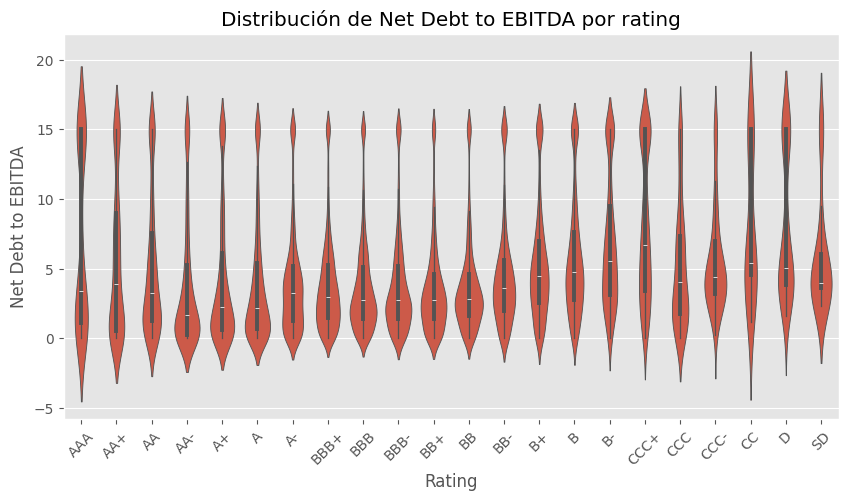

In [35]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='Rating', y='Net Debt to EBITDA', data=df, order=All_rating_order)
plt.title('Distribución de Net Debt to EBITDA por rating')
plt.xlabel('Rating')
plt.ylabel('Net Debt to EBITDA')
plt.xticks(rotation=45)
plt.show()

Vemos que pasaría si elimnasemos las compañias que hemos definido nosotros como 15. Ya que nos esta moviendo la media y haceindo más dificial la prediccinion del rating. Antes vemos que % de datos por rating perderiamos, par no quedarnos sin ndatos en un rating concreto.

In [36]:
mask = df['Net Debt to EBITDA']>14.9

serie_rating_filter = df[mask][['Rating']].value_counts()
serie_rating_count = df[['Rating']].value_counts()
serie_rating_filter = serie_rating_filter.reindex(serie_rating_count.index)

print(np.round(serie_rating_filter/serie_rating_count * 100,1))

df[mask][['EBITDA','Net Debt','Net Debt to EBITDA']].describe().transpose()

Rating
BBB        4.3
BBB+       4.5
A-         6.1
BBB-       5.7
BB         4.8
BB+        4.1
BB-        7.7
A          7.7
B+        10.0
B         11.0
A+        10.6
B-        16.3
AA-        8.8
AA        13.1
CCC+      26.7
AA+       16.4
CCC        8.0
AAA       33.3
D         30.8
CCC-       8.1
SD        14.7
CC        28.6
Name: count, dtype: float64


,count,mean,std,min,25%,50%,75%,max
EBITDA,2394.0,-5092.433996,123021.645896,-4.141102e+06,-20.929710,28.584455,192.414250,1.499059e+04
Net Debt,2394.0,48193.813461,823767.698419,8.720000e-03,775.094364,2691.619710,7975.557454,2.417670e+07
Net Debt to EBITDA,2394.0,15.000000,0.000000,1.500000e+01,15.000000,15.000000,15.000000,1.500000e+01


Vemos como quedaría la distribución una vez eliminados los extremos

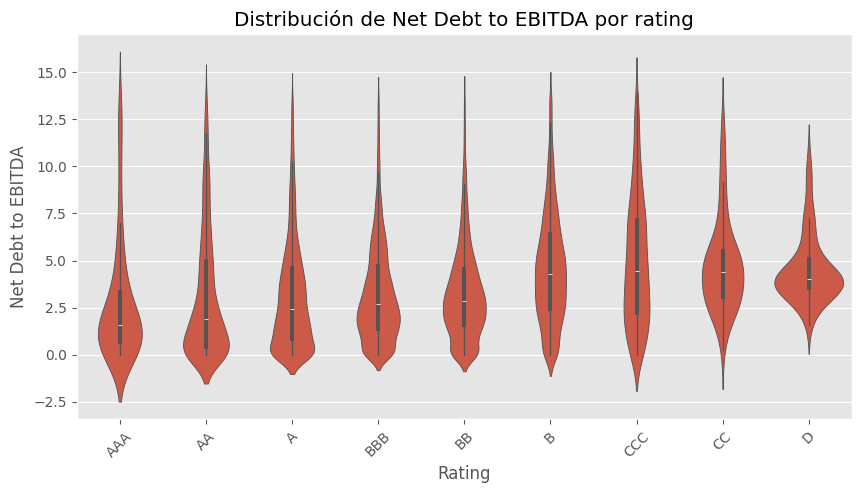

In [37]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='Rating_group', y='Net Debt to EBITDA', data=df[~mask], order=rating_order_group)
plt.title('Distribución de Net Debt to EBITDA por rating')
plt.xlabel('Rating')
plt.ylabel('Net Debt to EBITDA')
plt.xticks(rotation=45)
plt.show()

XXX Problema: Como la agrupacion de datos extremos en 15 nos esta distorisneod la media, los quitamos.

Finalmente decidimos quitarlos porque si no se sesgan mucho los datos

In [38]:
df = df[~mask]

### Debt to assets
2) Debt to Assets, esto debería de ser un % que vaya de 0 a 100% reflejando el apalancamiento de la compañía, analizaremos el numerodos y denominados

In [39]:
variable = 'Debt to Assets'
df[[variable,'Total Debt','Total Assets', 'Total Equity']].describe()

,Debt to Assets,Total Debt,Total Assets,Total Equity
count,29248.000000,29248.000000,2.924800e+04,29248.000000
mean,0.514535,5825.642245,2.456961e+04,6932.489906
std,1.694778,13167.170077,6.496442e+04,17647.738975
min,-169.392654,0.000545,7.438200e-01,-105345.780000
25%,0.328881,718.086680,2.402256e+03,704.858935
50%,0.475398,1960.050750,6.258631e+03,2058.495248
75%,0.624332,5285.393070,1.854113e+04,6262.874911
max,204.905106,278873.832930,1.415340e+06,452777.949000


Borramos todos los que tengas equity negatio

In [40]:
mask = df['Total Equity']<0

serie_rating_filter = df[mask][['Rating']].value_counts()
serie_rating_count = df[['Rating']].value_counts()
serie_rating_filter = serie_rating_filter.reindex(serie_rating_count.index)

print(np.round(serie_rating_filter/serie_rating_count * 100,1))


Rating
BBB        2.1
BBB+       1.4
A-         1.4
BBB-       1.6
BB         3.3
BB+        3.5
BB-        6.4
A          0.9
B+         8.9
B         14.5
A+         1.1
B-        22.0
AA-        2.2
AA         0.6
CCC+      22.1
AA+        1.1
CCC       15.0
AAA       12.1
CCC-      20.6
D          5.6
SD        31.0
CC         NaN
Name: count, dtype: float64


En este caoso pas lo mismo, estamos perdiendo un % muy alto de las rating que tenemos pocos pero esta vez si que los tenemos que quitar ya que tener el Total Equity negativo sería sinónimo de quibra

In [41]:
print(df.shape)
df = df[df['Total Equity']>=0]

(29248, 25)


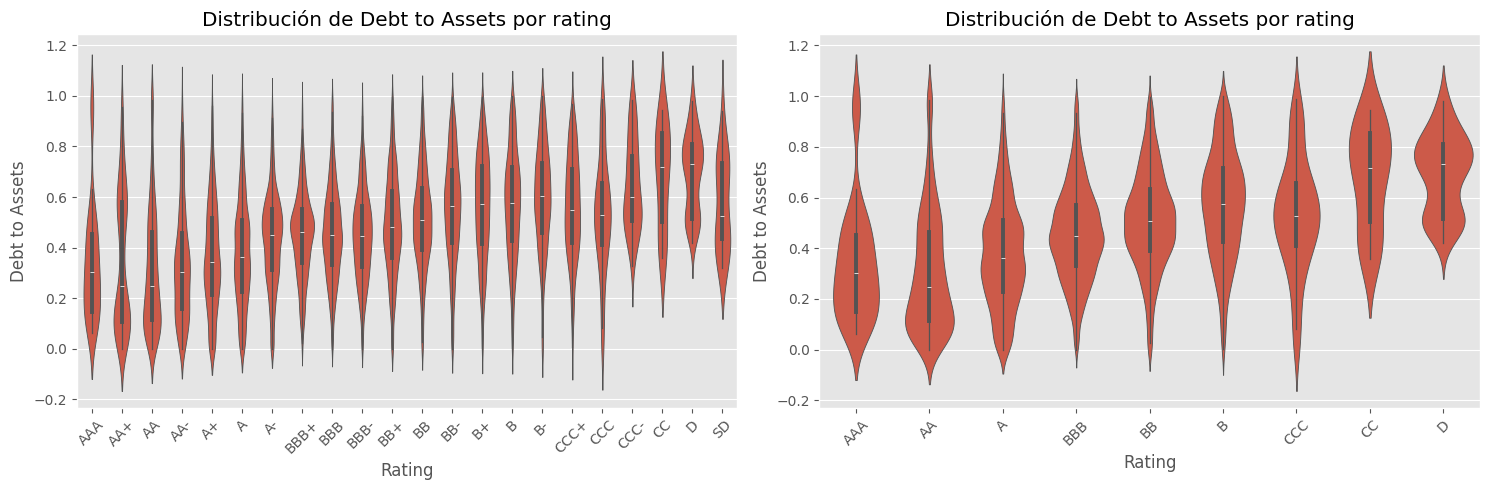

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=All_rating_order, ax=axs[0])
axs[0].set_title(f'Distribución de {variable} por rating')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel(variable)
axs[0].tick_params(axis='x', rotation=45)

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=rating_order_group, ax=axs[1])
axs[1].set_title(f'Distribución de {variable} por rating')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel(variable)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [43]:
df[['Total Equity','Net Debt to EBITDA']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Total Equity,27985.0,7323.739108,17863.761262,0.10825,831.852271,2255.112000,6604.824730,452777.949000
Net Debt to EBITDA,27985.0,3.384899,2.786148,0.00000,1.285500,2.806533,4.883768,13.929546


Nota: Aunque se vean valores negativos en el violin realmente el max o min lo marca la linea negra vertical

### Long Term Debt to equity 
3) Te dice cuantas veces tu LT Debt es tu equity, asi que deberá de ser un %. Puede ir desde 0 (en caso de no tener LT Debt) hasta inf (pero lo limitaremos igual euigual que el Debt to EBTIDA=). The goal of this ratio is to determine how much leverage the company is taking. A higher ratio means the company is taking on more debt. This, in turn, often makes them more prone to financial risk.


In [44]:
variable = 'Long Term Debt to Equity'
df[[variable,'Long Term Debt', 'Total Equity']].describe()

,Long Term Debt to Equity,Long Term Debt,Total Equity
count,27985.000000,27985.000000,27985.000000
mean,1.732821,4364.240435,7323.739108
std,11.043657,8891.422886,17863.761262
min,-0.001139,-1.712520,0.108250
25%,0.359031,563.879379,831.852271
50%,0.707251,1579.029450,2255.112000
75%,1.225975,4238.000000,6604.824730
max,634.036352,162672.380700,452777.949000


No puede ser negativo

In [45]:
sum(df['Long Term Debt']<0)

1

In [46]:
df = df[df['Long Term Debt']>=0]

Percentile 95 is 4.001095988055086


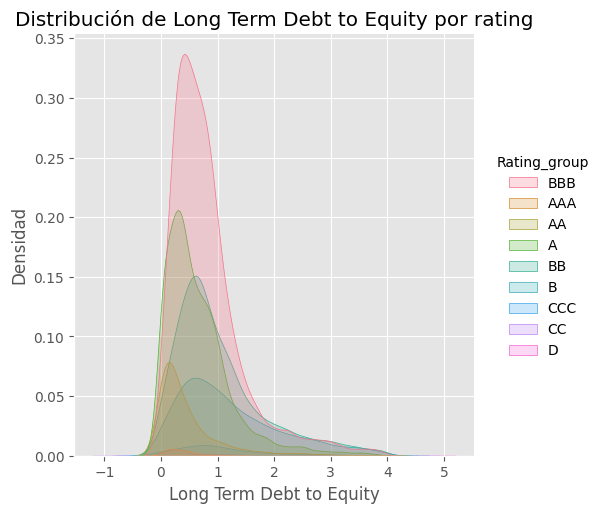

In [47]:
percentile = 95
df_test = df

value_percentile = np.percentile(df_test[variable], percentile)
print(f"Percentile {percentile} is {value_percentile}")
df_test = df_test[df_test[variable] <= value_percentile]

sns.displot(data=df_test, x=variable, hue='Rating_group', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

Para priorizar el no distorsionar los datos, quitamos los extremos, aunuqe perdamos un pct muy alto de los ratings que tenenmos pocos

In [48]:
mask = df[variable]>value_percentile

serie_rating_filter = df[mask][['Rating']].value_counts()
serie_rating_count = df[['Rating']].value_counts()
serie_rating_filter = serie_rating_filter.reindex(serie_rating_count.index)

print(np.round(serie_rating_filter/serie_rating_count * 100,1))

Rating
BBB        3.2
BBB+       1.9
A-         2.5
BBB-       2.0
BB         6.3
BB+        5.1
BB-       11.2
A          2.5
B+        10.7
B         13.2
A+         2.2
AA-        2.1
B-        14.3
AA         4.1
AA+        4.0
CCC+      10.7
CCC       12.2
AAA        7.8
CCC-      16.7
D         17.6
SD         5.0
CC        33.3
Name: count, dtype: float64


In [49]:
df = df[~mask]

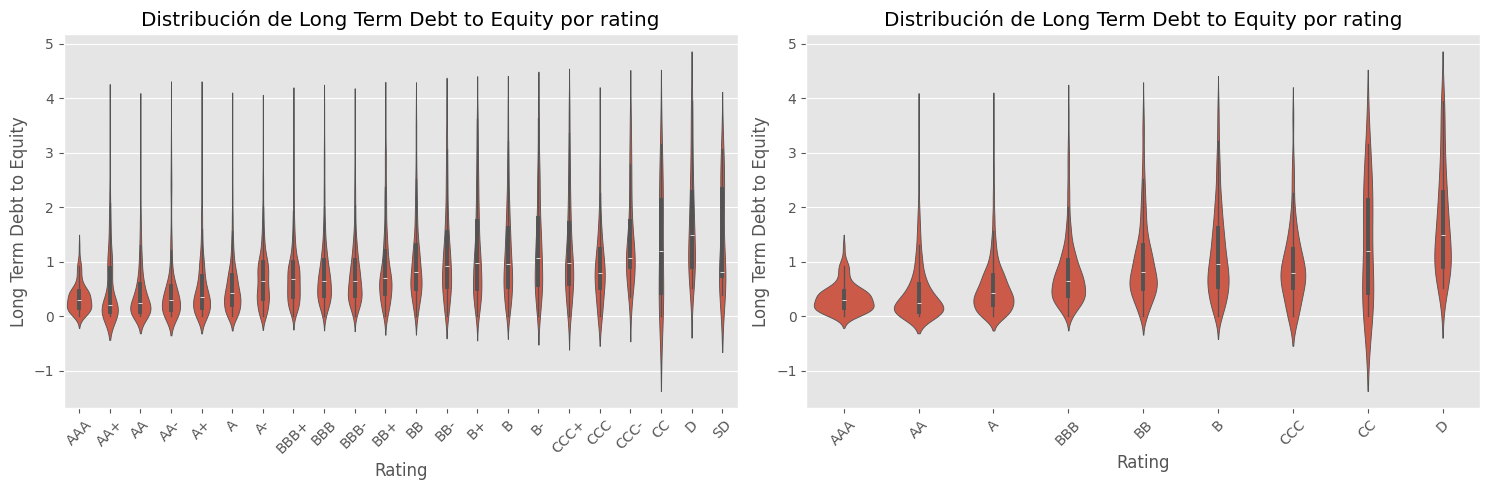

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=All_rating_order, ax=axs[0])
axs[0].set_title(f'Distribución de {variable} por rating')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel(variable)
axs[0].tick_params(axis='x', rotation=45)

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=rating_order_group, ax=axs[1])
axs[1].set_title(f'Distribución de {variable} por rating')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel(variable)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Debt to equity
4) Debt to equity, esto debería de ser un % que vaya de 0 a 100% reflejando el ¿? de la compañía, analizaremos el numerodos y denominados

In [51]:
variable = 'Debt to Equity'
df[[variable,'Total Debt', 'Total Equity']].describe()

,Debt to Equity,Total Debt,Total Equity
count,2.658400e+04,26584.000000,26584.000000
mean,1.067186e+00,5858.152127,7674.097444
std,1.063310e+00,13284.068205,18258.329569
min,8.096746e-07,0.000545,0.108250
25%,4.582910e-01,704.867921,948.638750
50%,8.310432e-01,1954.817035,2462.634179
75%,1.359321e+00,5312.556875,6985.843050
max,8.621513e+01,278873.832930,452777.949000


Percentile: 95 Value:2.9154189848391256


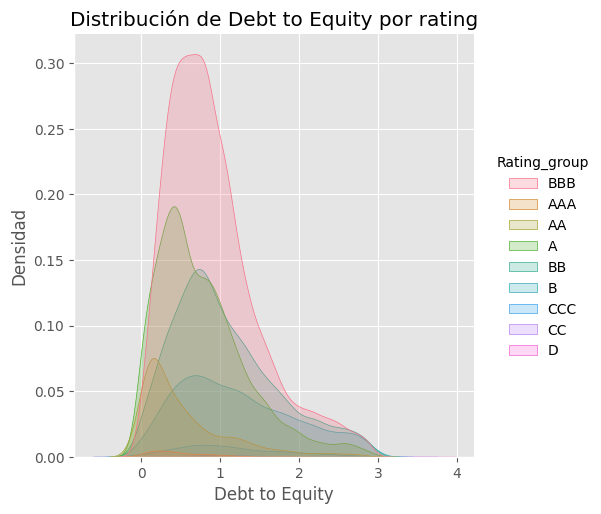

In [52]:
percentile = 95
df_test = df
value_percentile = np.percentile(df_test[variable], percentile)
print(f"Percentile: {percentile} Value:{value_percentile}")
df_test = df_test[df_test[variable] <= value_percentile]

sns.displot(data=df_test, x=variable, hue='Rating_group', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

In [53]:
mask = df[variable]>value_percentile
print(sum(mask))
serie_rating_filter = df[mask][['Rating']].value_counts()
serie_rating_count = df[['Rating']].value_counts()
serie_rating_filter = serie_rating_filter.reindex(serie_rating_count.index)

print(np.round(serie_rating_filter/serie_rating_count * 100,1))

1330
Rating
BBB        3.6
BBB+       2.7
A-         2.5
BBB-       3.6
BB         6.1
BB+        6.3
A          2.8
BB-        9.6
B+        12.6
B          8.5
A+         2.9
AA-        4.7
B-         9.6
AA         2.0
AA+        4.7
CCC+      11.9
CCC        5.4
AAA        NaN
CCC-      17.8
D         31.0
SD        21.1
CC        10.0
Name: count, dtype: float64


Quiamos los datos extremos.

In [54]:
df = df[~mask]

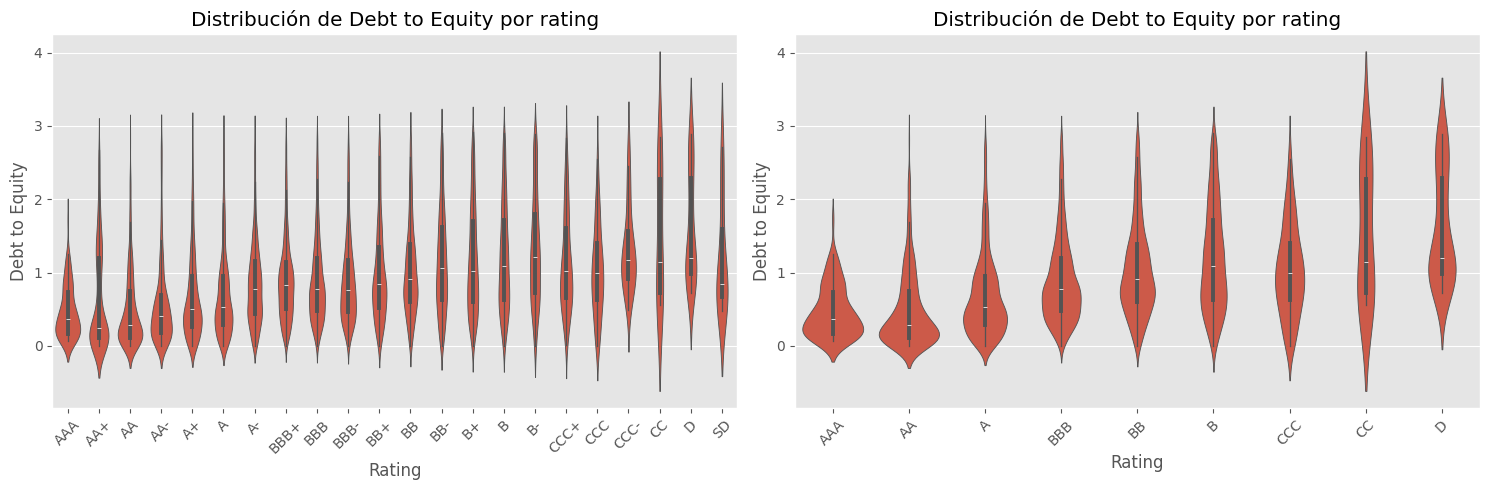

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=All_rating_order, ax=axs[0])
axs[0].set_title(f'Distribución de {variable} por rating')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel(variable)
axs[0].tick_params(axis='x', rotation=45)

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=rating_order_group, ax=axs[1])
axs[1].set_title(f'Distribución de {variable} por rating')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel(variable)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Financila Leverage 
5) Financial Leverage, deberia ir de 0 a 100%

In [56]:
variable = 'Financial Leverage'
df[[variable,'Total Assets', 'Total Debt']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Financial Leverage,25254.0,3.883451,33.227503,0.948118,2.011836,2.625371,3.490623,4.487504e+03
Total Assets,25254.0,26719.100463,68687.548628,3.729932,2676.265590,6975.071900,20360.035077,1.415340e+06
Total Debt,25254.0,5770.790660,13206.466311,0.000545,691.529125,1905.007534,5238.351877,2.788738e+05


Percentile: 95 Value:6.9934398182281425


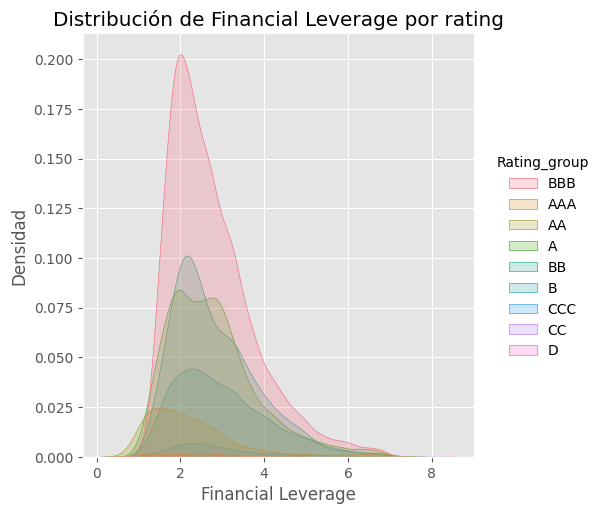

In [57]:
percentile = 95
df_test = df

value_percentile = np.percentile(df_test[variable], percentile)
print(f"Percentile: {percentile} Value:{value_percentile}")
df_test = df_test[df_test[variable] <= value_percentile]

sns.displot(data=df_test, x=variable, hue='Rating_group', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

In [58]:
mask = df[variable]>value_percentile
print(sum(mask))
serie_rating_filter = df[mask][['Rating']].value_counts()
serie_rating_count = df[['Rating']].value_counts()
serie_rating_filter = serie_rating_filter.reindex(serie_rating_count.index)

print(np.round(serie_rating_filter/serie_rating_count * 100,1))

1263
Rating
BBB        2.2
BBB+       5.2
A-         7.3
BBB-       1.3
BB         1.4
BB+        2.0
A         11.4
BB-        1.6
B+         1.2
A+        19.4
B          1.1
AA-       18.1
B-         1.7
AA        12.4
AA+       11.8
CCC+       1.3
CCC        3.3
AAA        NaN
CCC-       NaN
D          6.9
SD         NaN
CC         NaN
Name: count, dtype: float64


In [59]:
df = df[~mask]

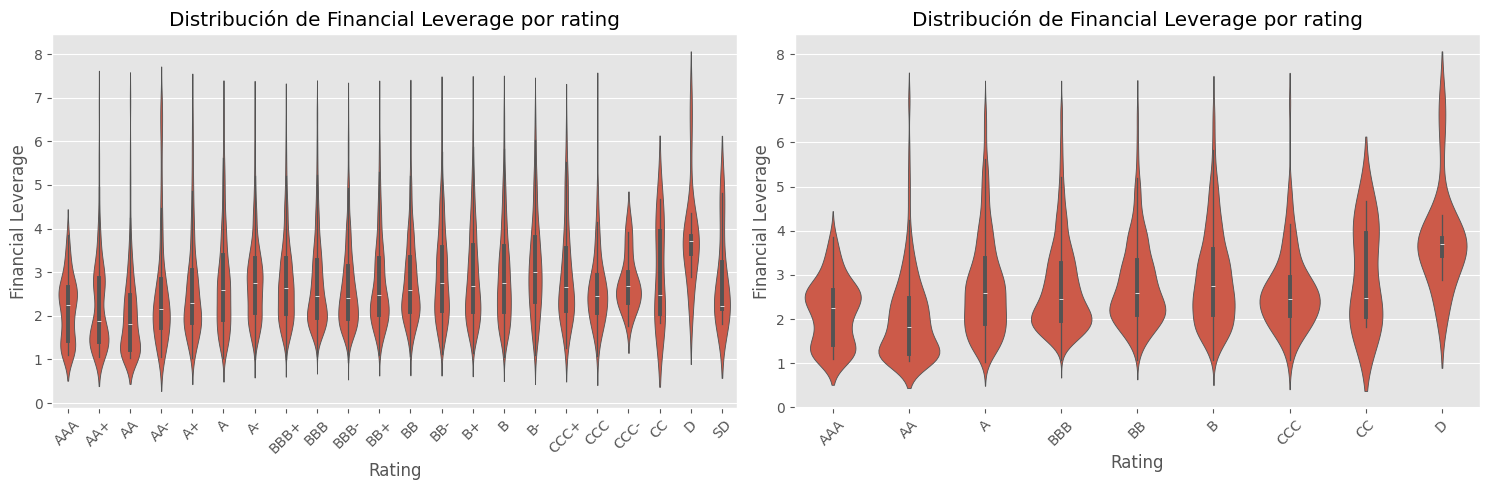

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=All_rating_order, ax=axs[0])
axs[0].set_title(f'Distribución de {variable} por rating')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel(variable)
axs[0].tick_params(axis='x', rotation=45)

# violin plot of the column varaible by rating
sns.violinplot(x='Rating', y=variable, data=df, order=rating_order_group, ax=axs[1])
axs[1].set_title(f'Distribución de {variable} por rating')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel(variable)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Cash Ratio

In [61]:
df[["Cash ratio","Cash and equivalents","Current Liabilities"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cash ratio,23991.0,0.476337,1.590193,-0.012686,0.101533,0.260253,0.540472,186.906398
Cash and equivalents,23991.0,1269.393786,3401.979983,-1.689010,56.125210,262.045450,974.807242,77540.191200
Current Liabilities,23991.0,4607.954614,12610.974317,0.970040,315.681559,964.416000,3390.226064,250500.271850


Simplemente quitamos los ue sean menor que 0

In [62]:
sum(df["Cash ratio"]<0)

1

In [63]:
df = df[df["Cash ratio"]>=0]

## Eliminmos los outliers

Vemos uque no podemos eliminarlos porque nos uedaramiamos sin empreas con ciertos ratings

In [64]:
ratios_to_delete_extrems = {'Current Ratio':95,'Quick Ratio':95,'Cash ratio':95,'Debt ratio':90}

for ratio,percentile  in ratios_to_delete_extrems.items():
    mask = df[ratio] < np.percentile(df[ratio], percentile)
    print(ratio,df[~mask].shape)
    print('Estos ratings son los que faltan:   ',set(All_rating_order)-set(df[mask]['Rating'].unique()))
    df = df[mask]
print(set(All_rating_order)-set(df['Rating'].unique()))

Current Ratio (1200, 25)
Estos ratings son los que faltan:    set()
Quick Ratio (1140, 25)
Estos ratings son los que faltan:    set()
Cash ratio (1083, 25)
Estos ratings son los que faltan:    set()
Debt ratio (2057, 25)
Estos ratings son los que faltan:    set()
set()


In [65]:
df[var_x_num].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Net Debt to EBITDA,18510.0,3.567293,2.519380,0.000000,1.739831,3.049874,4.828270,13.929546
Debt to Assets,18510.0,0.469906,0.139220,0.122095,0.367863,0.473965,0.572462,0.744499
Current Ratio,18510.0,1.277071,0.624645,0.006681,0.833683,1.184797,1.614325,3.892211
Quick Ratio,18510.0,0.752621,0.381205,0.000000,0.461727,0.707817,0.999582,1.950050
Cash ratio,18510.0,0.270186,0.227304,0.000000,0.084765,0.215814,0.401266,0.935825
Long Term Debt to Equity,18510.0,0.844268,0.546377,0.000000,0.442600,0.727747,1.098678,2.910016
Debt to Equity,18510.0,1.036044,0.599355,0.139076,0.581936,0.901015,1.338972,2.913875
Debt ratio,18510.0,3.348730,1.403216,1.331217,2.331621,2.982527,3.947663,8.490142
Financial Leverage,18510.0,2.871146,1.008557,1.151769,2.117619,2.676034,3.390399,6.989512


## Datos limpios


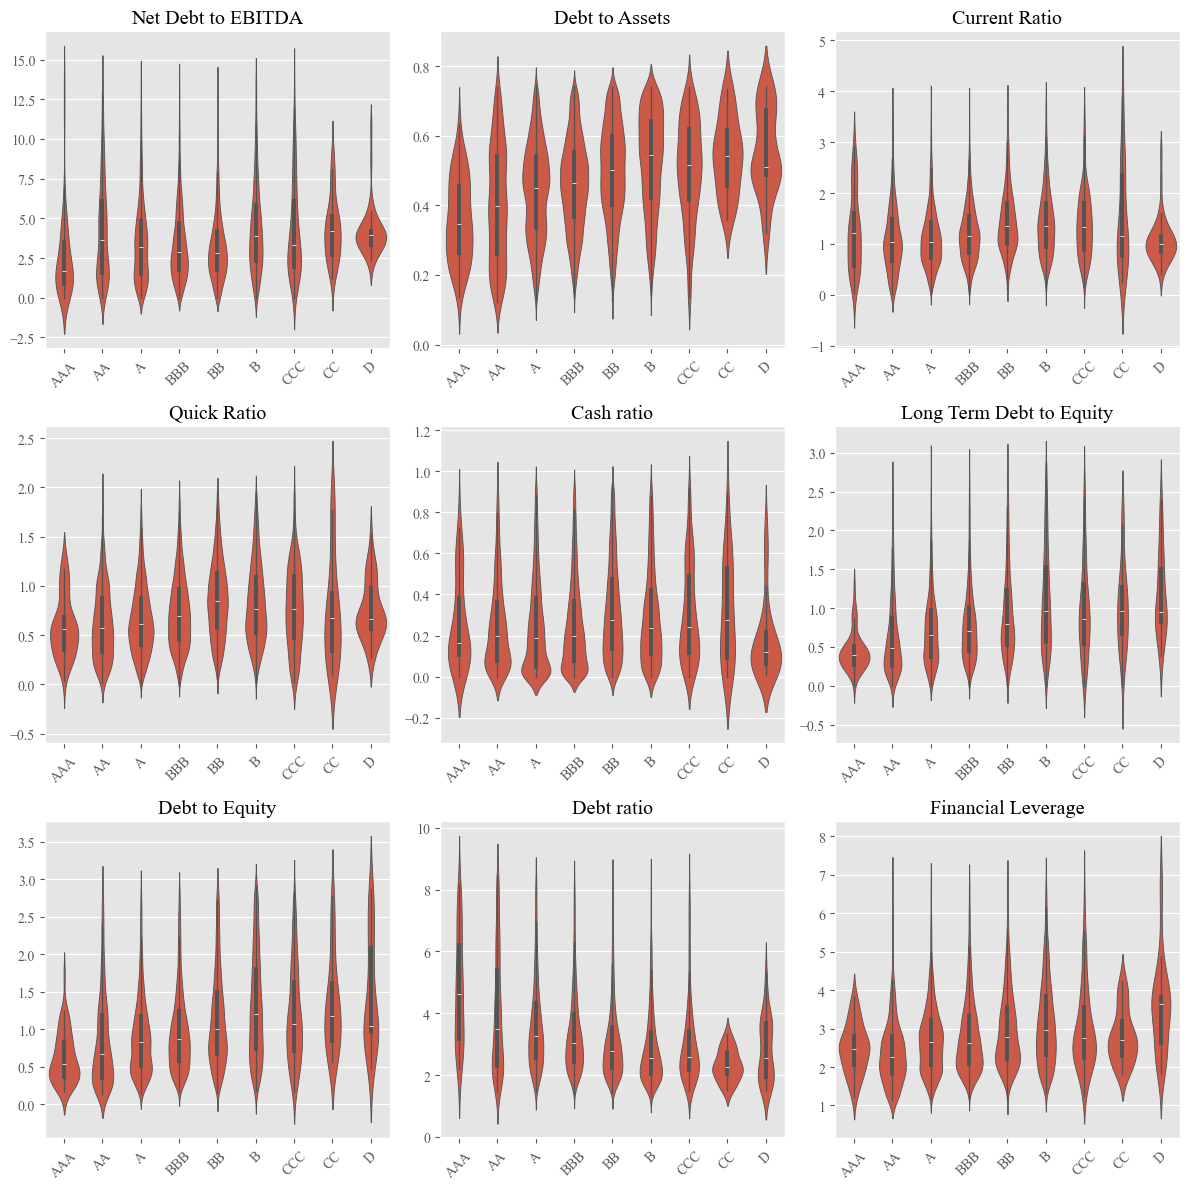

In [68]:
#Gráfico con la distribución de los datos por Rating
fig, axes = plt.subplots(3, 3, figsize=(4*3, 4*3))
# change the font size to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

for i, y in enumerate(var_x_num):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    sns.violinplot(x='Rating_group', y=y, data=df, ax=ax, order=rating_order_group)
    # dont show the x and y title
    ax.set_xlabel('')
    ax.set_ylabel('')
    # rotate the x ticks
    ax.tick_params(axis='x', rotation=45)
    # Use Times New Roman
    ax.set_title(y, fontname='Times New Roman')

plt.tight_layout()
plt.savefig("plots/distribution_metricas_por_rating.png")
plt.show()

VEmos que hay cierta correlacion entre el rating y los datos asi que es probable que en la regresiones podamos predecir el rating. Vemos ademaas si hay NaN en los datos

In [67]:
df.isna().sum()

Excel Company ID            0
Rating                      0
Sector                      0
Current Assets              0
Cash and equivalents        0
Receivables                 0
Total Assets                0
Current Liabilities         0
Long Term Debt              0
Total Debt                  0
Total Equity                0
Gastos financieros netos    0
EBITDA                      0
year                        0
Net Debt to EBITDA          0
Debt to Assets              0
Long Term Debt to Equity    0
Financial Leverage          0
Current Ratio               0
Quick Ratio                 0
Cash ratio                  0
Debt to Equity              0
Debt ratio                  0
Rating_group                0
Net Debt                    0
dtype: int64

In [69]:
sum(df['Sector']=='0')

2

In [70]:
df = df[df['Sector']!='0']

In [72]:
df.to_csv('all_data_clean.csv', index=False)

## Ajustes <a id="ajustes"></a>
Ya que los datos no están uniformement distribuidos, dusplicaremos los que tiene menor represtnatitivada

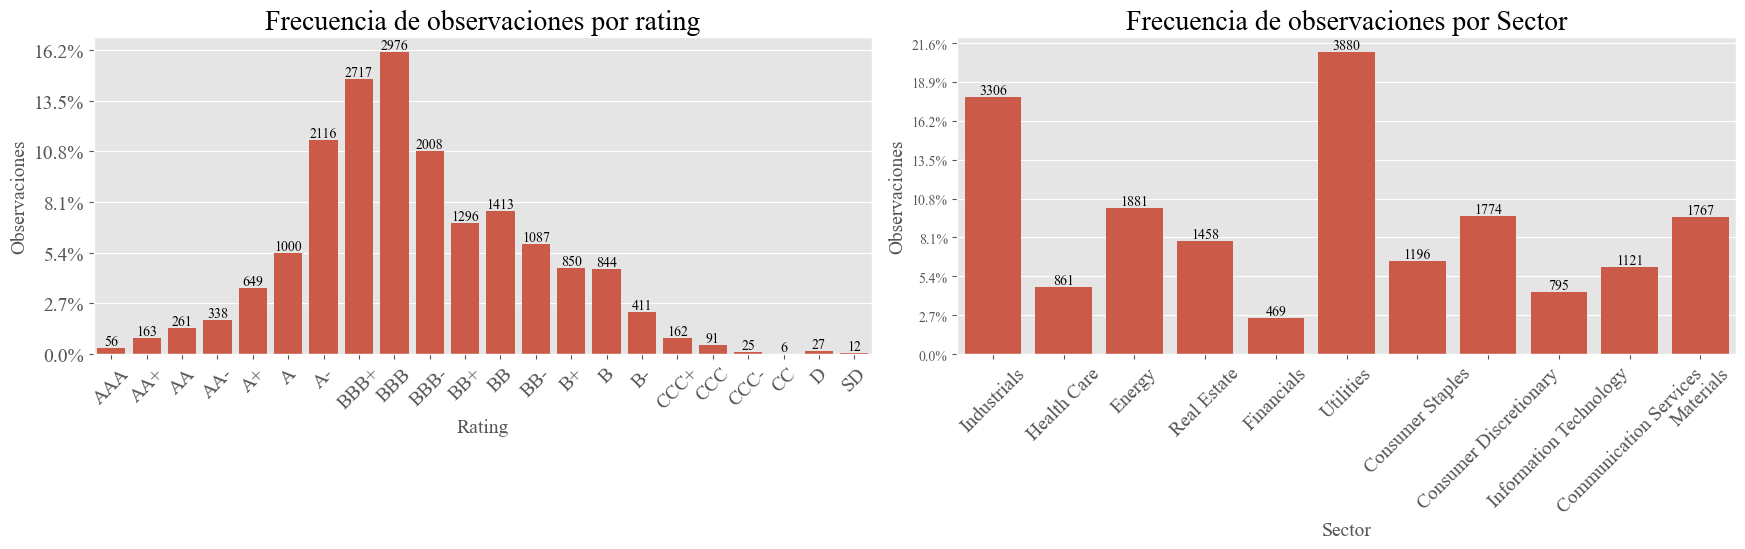

In [84]:
# create a figure and subplots with one row and three columns
fig, axs = plt.subplots(1, 2, figsize=(22*0.8, 7*0.8))

# plot the number of observations per rating
sns.countplot(x='Rating', data=df, order=All_rating_order, ax=axs[0])
axs[0].set_title('Frecuencia de observaciones por rating',fontsize=20)
axs[0].set_ylabel('Observaciones',fontsize=14)
axs[0].set_xlabel('Rating',fontsize=14)
axs[0].tick_params(axis='x', rotation=45, labelsize=14)
# increase the zie of the y ticks
axs[0].tick_params(axis='y', labelsize=14)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))

# plot the results by Rating_group
#sns.countplot(x='Rating_group', data=df, order=All_rating_order_group.values(), ax=axs[1])
#axs[1].set_title('Frecuencia de observaciones por rating genérico')
#axs[1].set_ylabel('Pct de observaciones')
#axs[1].set_xlabel('Rating')
#axs[1].tick_params(axis='x', rotation=45)
#axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))

# plot the number of observations per sector different from 0
sns.countplot(x='Sector', data=df[df['Sector'] != '0'], ax=axs[1])
axs[1].set_title('Frecuencia de observaciones por Sector',fontsize=20)
axs[1].set_ylabel('Observaciones',fontsize=14)
axs[1].set_xlabel('Sector',fontsize=14)
axs[1].tick_params(axis='x', rotation=45,labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))


# add the number of values above each column without decimals
for ax in axs:
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# adjust the spacing between subplots
plt.tight_layout()
plt.savefig("plots/distribution_rating_sectores.png")
# display the plot
plt.show()

In [74]:
df['Sector'].value_counts()

Sector
Utilities                 3880
Industrials               3306
Energy                    1881
Consumer Discretionary    1774
Materials                 1767
Real Estate               1458
Consumer Staples          1196
Communication Services    1121
Health Care                861
Information Technology     795
Financials                 469
Name: count, dtype: int64

### Para los ratings genericos

Veamos cuantos valores tenemos por cada variable dependiente, categórica, ratings. Ya que si tenemos muchos ratings de BBB por ejemplo, nuestro modelo estará sesgado.

*Ordinal data can be encoded one of three ways, broadly speaking, but I think it’s safe to say that its encoding is often not carefully considered.*

*1.It can be assumed to be close enough to interval data — with relatively equal magnitudes between the values — to treat it as such. Social scientists make this assumption all the time with Likert scales. For example, “On a scale from 1 to 7, 1 being extremely unlikely, 4 being neither likely nor unlikely and 7 being extremely likely, how likely are you to recommend this movie to a friend?”. Here the difference between 3 and 4 and the difference between 6 and 7 can be reasonably assumed to be similar.*

*2.It can be treated as nominal data, where each category has no numeric relationship to another. One-hot encoding and other encodings appropriate for nominal data make sense here.*

*3.The magnitude of the difference between the numbers can be ignored. You can just train your model with different encodings and seeing which encoding works best.*

Over Ssample the data for Rating

In [ ]:
from sklearn.utils import resample

In [75]:
rating_mas_frecuente = 'BBB'
df_oversampled = pd.DataFrame()

# Oversample each rating
for rating in df['Rating'].unique():
    rating_data = df[df['Rating'] == rating]
    oversampled_rating_data = resample(rating_data, replace=True, n_samples=len(df[df['Rating'] == rating_mas_frecuente]), random_state=42)
    df_oversampled = pd.concat([df_oversampled, oversampled_rating_data])

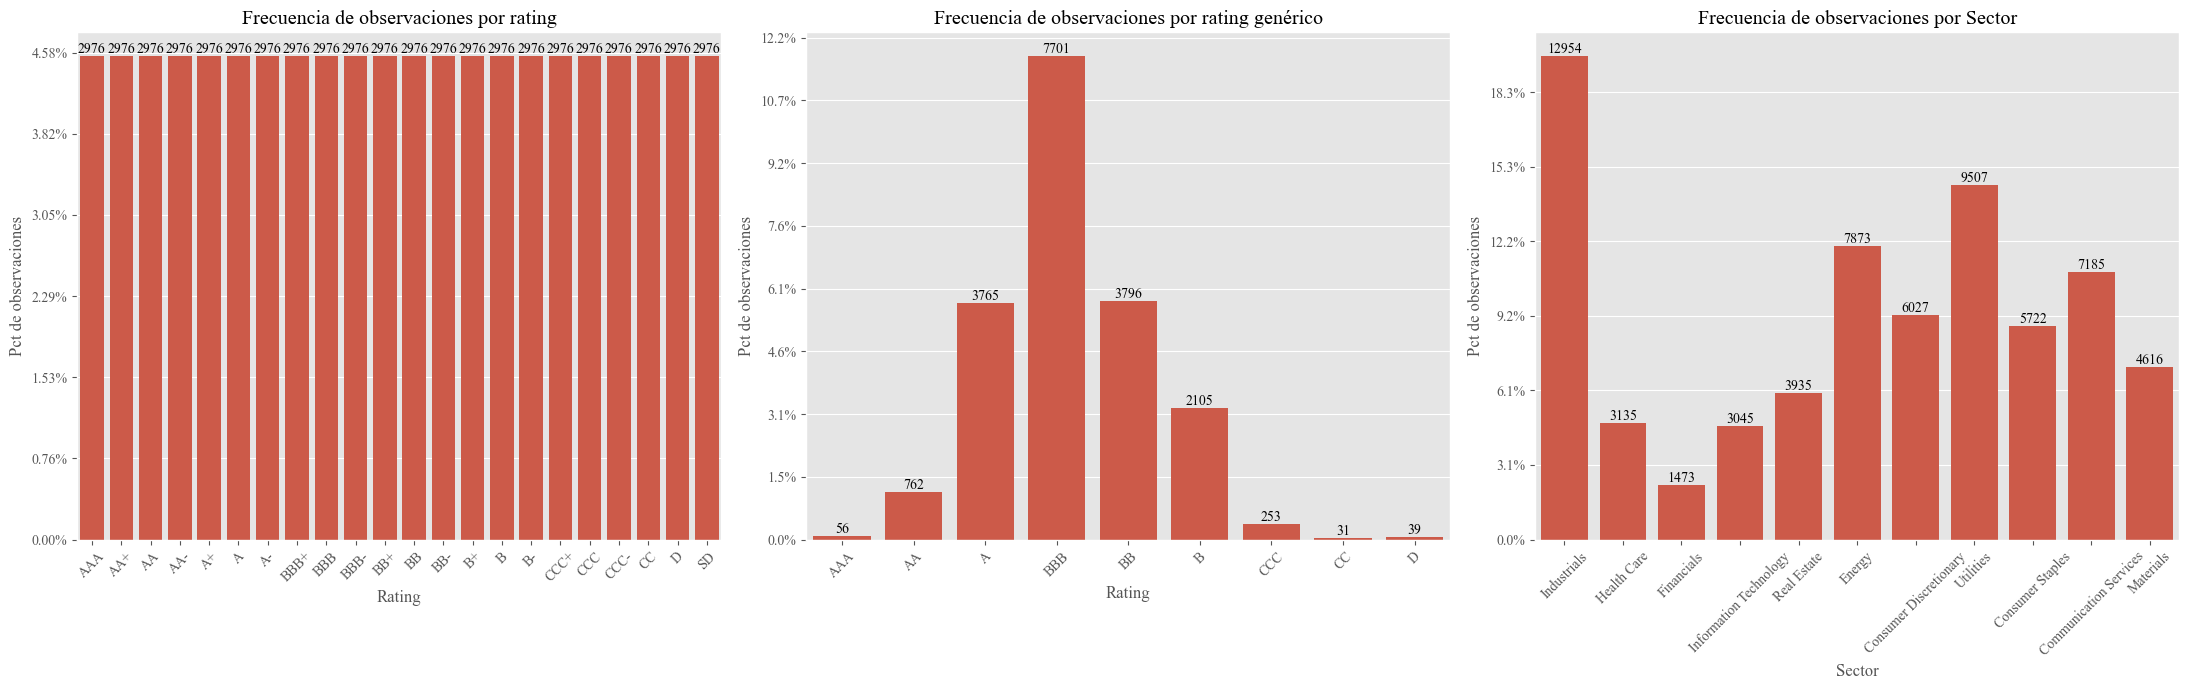

In [79]:
# create a figure and subplots with one row and three columns
fig, axs = plt.subplots(1, 3, figsize=(22, 7))

# plot the number of observations per rating
sns.countplot(x='Rating', data=df_oversampled, order=All_rating_order, ax=axs[0])
axs[0].set_title('Frecuencia de observaciones por rating')
axs[0].set_ylabel('Pct de observaciones')
axs[0].set_xlabel('Rating')
axs[0].tick_params(axis='x', rotation=45)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(len(df_oversampled)))

# plot the results by Rating_group
sns.countplot(x='Rating_group', data=df, order=All_rating_order_group.values(), ax=axs[1])
axs[1].set_title('Frecuencia de observaciones por rating genérico')
axs[1].set_ylabel('Pct de observaciones')
axs[1].set_xlabel('Rating')
axs[1].tick_params(axis='x', rotation=45)
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(len(df_oversampled)))

# plot the number of observations per sector different from 0
sns.countplot(x='Sector', data=df_oversampled[df_oversampled['Sector'] != '0'], ax=axs[2])
axs[2].set_title('Frecuencia de observaciones por Sector')
axs[2].set_ylabel('Pct de observaciones')
axs[2].set_xlabel('Sector')
axs[2].tick_params(axis='x', rotation=45)
axs[2].yaxis.set_major_formatter(mtick.PercentFormatter(len(df_oversampled)))

# add the number of values above each column without decimals
for ax in axs:
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# adjust the spacing between subplots
plt.tight_layout()

# display the plot
plt.show()

Ahora vemos que se ditribuyen igual poar todos los darings que tenemos. 

In [80]:
df_oversampled.to_csv('all_data_clean_oversampled.csv', index=False)

### Para los  ratings agrupados
 
Oversample the data for rating group

In [81]:
df_oversampled = pd.DataFrame()

# Oversample each rating
for rating in df['Rating_group'].unique():
    rating_data = df[df['Rating_group'] == rating]
    oversampled_rating_data = resample(rating_data, replace=True, n_samples=len(df[df['Rating_group'] == rating_mas_frecuente]), random_state=42)
    df_oversampled = pd.concat([df_oversampled, oversampled_rating_data])

Vemos que aunque la distriubcion por rating group es igual por ratings normal no lo es

In [83]:
df_oversampled['Rating_group'].value_counts()

Rating_group
AAA    7701
AA     7701
A      7701
BBB    7701
BB     7701
B      7701
CCC    7701
CC     7701
D      7701
Name: count, dtype: int64

Poer en cambio para las indsutrias no, pero no importa porque esta variable no la que vamos a predicir

In [85]:
df_oversampled['Sector'].value_counts()

Sector
Industrials               15045
Utilities                 10163
Energy                     8365
Communication Services     8140
Consumer Discretionary     5832
Materials                  4907
Consumer Staples           4395
Information Technology     3795
Health Care                3663
Real Estate                3509
Financials                 1495
Name: count, dtype: int64

In [86]:
df_oversampled.to_csv('all_data_clean_oversampled_group.csv', index=False)